# Necessary Imports and Extensions

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# warnings.filterwarnings('ignore')
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
from wordcloud import STOPWORDS
from scipy.sparse import csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import string
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from wordcloud import WordCloud
import gensim
import time
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import multiprocessing
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression




<br><br>

# From Here, Initiates the Training Phase of Model.

<strong><p style="color:blue;font-size:20px;"> Data Preprocessing is completed in the file named "Data Preprocessing.ipynb".</p>
   

In [28]:
train_data = pd.read_csv("preprocessed_tokenized_training_data.csv")
train_data['concatenated_description'] = train_data['concatenated_description'].map(str)

In [30]:
train_data['concatenated_description'] = train_data['concatenated_description'].apply(gensim.utils.simple_preprocess)

In [33]:
train_data

,Unnamed: 0,train_id,item_condition_id,price,shipping,concatenated_description
0,0,0,3,10.0,1,"[mlb, cincinnati, reds, shirt, size, xl, not, ..."
1,1,1,3,52.0,0,"[razer, blackwidow, chroma, keyboard, razer, k..."
2,2,2,1,10.0,1,"[avaviv, blouse, target, adorable, top, hint, ..."
3,3,3,1,35.0,1,"[leather, horse, statues, not, known, new, tag..."
4,4,4,1,44.0,0,"[gold, plated, rose, not, known, complete, cer..."
...,...,...,...,...,...,...
1481656,1481656,1482530,2,20.0,1,"[free, people, inspired, dress, free, people, ..."
1481657,1481657,1482531,2,14.0,0,"[little, mermaid, handmade, dress, disney, lit..."
1481658,1481658,1482532,2,12.0,0,"[day, fix, containers, eating, plan, not, know..."
1481659,1481659,1482533,3,45.0,1,"[world, markets, lanterns, not, known, one, se..."


<br><br>




<strong><p style="color:red;font-size:30px;">Run the next cell only if you want to train the model.</p><br><br>
<strong><p style="color:green;font-size:30px;">If already trained, Skip to the next cell and directly load the model.</p><br><br>
<strong><p style="color:blue;font-size:30px;">Note: I have trained the model and saved it as "word2vec_sg_model"</p>



In [13]:
cores = multiprocessing.cpu_count()

# Build the Word2Vec model
# Skip Gram
# Train the Word2Vec model

model1 = Word2Vec(vector_size=200, window=5, min_count=1, sg=1, workers=cores-1)
model1.build_vocab(train_data['concatenated_description'], progress_per=1000)
t = time.time()
model1.train(train_data['concatenated_description'], total_examples=model1.corpus_count, epochs=20)
print('Time to build vocab for Model-1: {} mins'.format(round((time.time() - t) / 60, 2)))
model1.save("word2vec_sg_model")

Time to build vocab for Model-1: 41.98 mins


<strong><p style="color:blue;font-size:30px;">Load the model.</p>


In [31]:
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:3500]
y_test = y_test[:3500]#Loading a pretrained model

model1 = Word2Vec.load("word2vec_sg_model")

In [32]:
def avg_word2vec1(doc):
    return np.mean([model1.wv[word] for word in doc if word in model1.wv.index_to_key], axis=0)

In [34]:
train_data_model1 = train_data.sample(frac=0.03, random_state=1)

series = train_data_model1.concatenated_description.apply(avg_word2vec1)

df = pd.DataFrame(series.apply(pd.Series))

train_data_model1 = pd.concat([train_data_model1, df], axis=1)

train_data_model1 = train_data_model1.drop(['concatenated_description'],axis=1)

In [5]:
train_data_model1

<strong><p style="color:blue;font-size:30px;">Saving the data set for future use.</p>

In [37]:
train_data_model1.to_csv('avgword2vec_sg.csv')

In [3]:
train_data_model1 = pd.read_csv('avgword2vec_sg.csv')



<strong><p style="color:green;font-size:30px;">"avgword2vec_sg.csv" Will be used for "train_test_split"</p>
    
 

# We've our dataset ready for the Model-1.

In [4]:
data = pd.read_csv('training_data_for_Model1.csv')

In [5]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
y = data['price']
X = data.drop(columns=['price'])

# Splitting the dataset

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = data.drop(columns=['price']).columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = data.drop(columns=['price']).columns)

In [66]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from scipy.stats import reciprocal
model = MLPRegressor()

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'max_iter' : [500, 1000, 2000],
    'activation': ['relu', 'tanh','logistic'],
    'alpha' : [0.00005, 0.005, 0.0005, 0.0001],
    'solver':['lbfgs','adam'],
    'random_state' : [6, 7, 42],
     'early_stopping' : [True],
     'validation_fraction' : [0.2],
    'learning_rate': ['invscaling','constant', 'adaptive']
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5, cv=5, verbose=3)

# Fit the data to perform random search
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam, validation_fraction=0.2;, score=0.279 total time=  23.0s
[CV 2/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam, validation_fraction=0.2;, score=0.316 total time= 1.9min
[CV 3/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam, validation_fraction=0.2;, score=0.326 total time=  28.9s
[CV 4/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, random_state=42, solver=adam, validation_fraction=0.2;, score=0.226 total time=  28.3s
[CV 5/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_l

In [18]:
best_model = MLPRegressor(validation_fraction= 0.2, 
                          solver= 'adam', 
                          random_state= 42, max_iter= 1000, 
                          learning_rate= 'constant', hidden_layer_sizes= (100,), 
                          early_stopping= True, alpha= 5e-05, activation= 'relu')

In [19]:
warnings.filterwarnings('ignore')

best_model.fit(X_train, y_train)

MLPRegressor(alpha=5e-05, early_stopping=True, max_iter=1000, random_state=42,
             validation_fraction=0.2)

In [24]:
y_K_pred = best_model.predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_K_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test,y_K_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R²) or Coefficient of Determination
r2 = r2_score(y_test, y_K_pred)
print("R-squared (R²):", r2)

# Explained Variance Score
explained_var = explained_variance_score(y_test, y_K_pred)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 1255.9387182525772
Root Mean Squared Error (RMSE): 35.43922570052254
Mean Absolute Error (MAE): 13.676529631260099
R-squared (R²): 0.2386649753170934
Explained Variance Score: 0.23932723014210566


In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

# Create an MLPRegressor model with desired hyperparameters
model = best_model

# Define the input features X and the target variable y

# Perform cross-validation with 5 folds
num_folds = 5
scores = cross_val_score(model, X, y, cv=num_folds, scoring='neg_mean_squared_error')

# Cross-validation returns negative mean squared error, so we take the absolute values
mse_scores = -scores

# Compute the mean and standard deviation of the cross-validation scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_mse)
# Print the results
print("Mean MSE:", mean_mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Standard Deviation of MSE:", std_mse)

Mean MSE: 1133.910032636651
Root Mean Squared Error (RMSE): 33.673580632844065
Standard Deviation of MSE: 279.5861079369809


# Kernelized Principal Component Analysis

In [27]:
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:3500]
y_test = y_test[:3500]

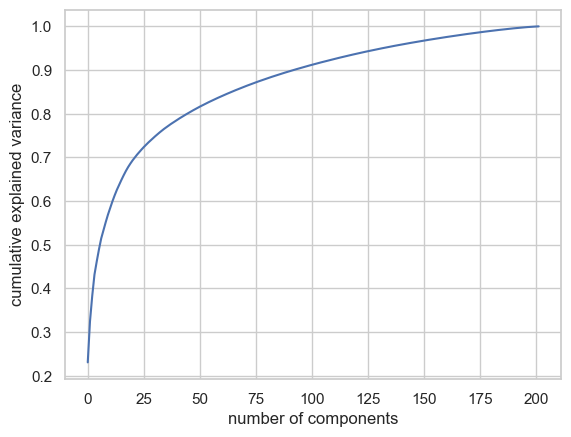

None

In [11]:
from sklearn.decomposition import KernelPCA
kpca_test = KernelPCA()
kpca_test = kpca_test.fit_transform(X_train)
explained_variance = np.var(kpca_test, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

sns.set(style='whitegrid')
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
display(plt.show())

evr = explained_variance_ratio
cvr = np.cumsum(explained_variance_ratio)

In [12]:
kpca_df = pd.DataFrame()
kpca_df['Cumulative Variance Ratio'] = cvr
kpca_df['Explained Variance Ratio'] = evr
display(kpca_df[kpca_df['Cumulative Variance Ratio'] >= 0.90])

,Cumulative Variance Ratio,Explained Variance Ratio
92,0.900457,0.001520
93,0.901961,0.001504
94,0.903450,0.001489
95,0.904927,0.001477
96,0.906396,0.001469
...,...,...
197,0.998787,0.000392
198,0.999150,0.000364
199,0.999477,0.000326
200,0.999752,0.000275


### From the above table, we can conclude that even if we use approx. half the number of components using Kernalized PCA, our new dataset will have a Cumulative Variance as 90% of the original dataset

# KPCA Tuned

In [28]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=175)
X_K_train = kpca.fit_transform(X_train)
X_K_test = kpca.transform(X_test)

In [29]:
K_mlp = MLPRegressor(hidden_layer_sizes=5,max_iter=2000)
K_mlp.fit(X_K_train, y_train)

MLPRegressor(hidden_layer_sizes=5, max_iter=2000)

In [30]:
y_K_pred = K_mlp.predict(X_K_test)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_K_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test,y_K_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R²) or Coefficient of Determination
r2 = r2_score(y_test, y_K_pred)
print("R-squared (R²):", r2)

# Explained Variance Score
explained_var = explained_variance_score(y_test, y_K_pred)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 1323.338666298721
Root Mean Squared Error (RMSE): 36.37772211531009
Mean Absolute Error (MAE): 14.765710471488964
R-squared (R²): 0.18120377976789592
Explained Variance Score: 0.18191274923045886


In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

# Create an MLPRegressor model with desired hyperparameters
model = K_mlp

# Define the input features X and the target variable y

# Perform cross-validation with 5 folds
num_folds = 5
scores = cross_val_score(model, X, y, cv=num_folds, scoring='neg_mean_squared_error')

# Cross-validation returns negative mean squared error, so we take the absolute values
mse_scores = -scores

# Compute the mean and standard deviation of the cross-validation scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_mse)
# Print the results
print("Mean MSE:", mean_mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Standard Deviation of MSE:", std_mse)

Mean MSE: 1230.183171305447
Root Mean Squared Error (RMSE): 35.07396714524103
Standard Deviation of MSE: 298.83053640786596


In [33]:
import pickle
filename = 'sg_PCA_model3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(K_mlp, file)


In [34]:
import pickle
filename = 'sg_model3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
